In [1]:
import boto3
import time
import json

session = boto3.Session(profile_name='nikita')
log_client = session.client('logs')


import numpy as np
import math
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Query results

In [2]:
query = log_client.start_query(
    logGroupName='/aws/batch/job',
    startTime=0,
    endTime=int(time.time()),
    queryString="""
        fields @message
        | filter success == 1
        | limit 5000
    """,
    limit=5000
)

In [3]:
query_result = {'status': 'Scheduled'}
while query_result['status'] in ('Scheduled', 'Running'):
    query_result = log_client.get_query_results(queryId=query['queryId'])
    time.sleep(1)

In [4]:
d = [
    json.loads(row[0]['value'])
    for row in query_result['results']
]
for row in d:
    if row['winner'] is None:
        row['winner'] = float('+inf')

data = pd.DataFrame(d)

In [5]:
data.head()

,player,opponent,duration,depth,score,winner,success
0,"UCTPlayer(0, td(seconds=3), c=0.6071067811865476)","UCTPlayer(1, td(seconds=3), c=math.sqrt(2) / 2)",474.3599,141,"[25, 21]",0.0,True
1,"UCTPlayer(0, td(seconds=3), c=0.9071067811865476)","UCTPlayer(1, td(seconds=3), c=math.sqrt(2) / 2)",420.6051,137,"[23, 21]",0.0,True
2,"UCTPlayer(0, td(seconds=3), c=0.8071067811865476)","UCTPlayer(1, td(seconds=3), c=math.sqrt(2) / 2)",464.0399,151,"[23, 22]",0.0,True
3,"UCTPlayer(0, td(seconds=3), c=0.9071067811865476)","UCTPlayer(1, td(seconds=3), c=math.sqrt(2) / 2)",270.9054,88,"[17, 26]",1.0,True
4,"UCTPlayer(0, td(seconds=3), c=math.sqrt(2) / 2)","UCTPlayer(1, td(seconds=3), c=0.9071067811865476)",252.3493,82,"[9, 28]",1.0,True


In [6]:
len(data)

1602

In [7]:
useful = data[(data.player.str.startswith('UCTPlayer')) & (data.opponent.str.startswith('UCTPlayer'))]

In [8]:
from datetime import timedelta as td
class UCTPlayer:
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs

useful['player'] = useful['player'].map(lambda x: eval(x).kwargs['c'])
useful['opponent'] = useful['opponent'].map(lambda x: eval(x).kwargs['c'])

In [11]:
is_normalized = np.isclose(useful['player'], math.sqrt(2) / 2)

to_normalise = useful[~is_normalized].copy()
to_normalise['opponent'] = to_normalise['player']
to_normalise['player'] = math.sqrt(2) / 2
to_normalise['winner'] = (to_normalise['winner'] + 1) % 2
to_normalise['score'] = to_normalise['score'].map(lambda x: list(reversed(x)))

normalised = pd.concat([useful[is_normalized], to_normalise])
normalised[normalised['winner'] == float('inf')] = 0.5

In [12]:
grouped = normalised.groupby('opponent').winner.agg(['mean', 'count'])

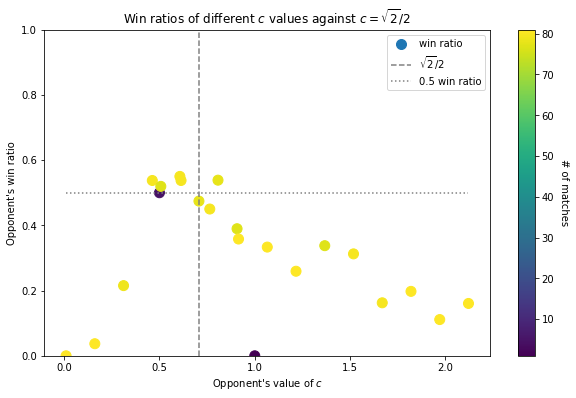

In [15]:
plt.figure(figsize=(10, 6))

plt.scatter(
    grouped.index,
    grouped['mean'],
    c=grouped['count'],
    label='win ratio',
    s=100
)

plt.vlines(math.sqrt(2) / 2, 0, 1, linestyles='dashed', label="$\sqrt{2}/2$", color="grey")
plt.hlines(0.5, grouped.index.min() , grouped.index.max(), linestyles='dotted', label="0.5 win ratio", color="grey")
plt.legend()
cb = plt.colorbar()
cb.set_label('# of matches', rotation=270)
cb.ax.set_yticklabels([int(i) for i in cb.get_ticks()])
cb.ax.get_yaxis().labelpad = 15

plt.ylim(0, 1)

plt.title("Win ratios of different $c$ values against $c = \sqrt{2}/2$");
plt.xlabel("Opponent's value of $c$")
plt.ylabel("Opponent's win ratio");